In [ ]:
# Install required packages 
!pip install pysptools
!pip install multiprocess
!pip install cvxopt
!pip install --upgrade seaborn

In [1]:

"""
Implementation of Linear Spectral Unmixing Analysis (LSMA) for fractional roof material type

"""

import os, sys
import numpy as np
import pandas as pd
import geopandas as gpd
import xarray as xr
import rioxarray as rxr
import earthpy.plot as ep
import pysptools.util as sp_utils
import pysptools.noise as noise
import pysptools.abundance_maps as amap
import seaborn as sns
import matplotlib.pyplot as plt
import multiprocess as mp
import cvxopt
import random
from osgeo import gdal
from osgeo import osr
from osgeo import gdal_array
from functools import partial
from functools import reduce

print(os.getcwd())

# Coordinate Ref. System
proj = 32618  # UTM Zone 18N

maindir = '/Users/max/Library/CloudStorage/OneDrive-Personal/mcook/earth-lab/opp-urban-fuels/rooftop-materials'

print("Completed ...")

/Users/max/Library/CloudStorage/OneDrive-Personal/mcook/earth-lab/opp-urban-fuels/rooftop-materials/code/aws
Completed ...


In [2]:

"""
Supporting functions for the OPP rooftop materials mapping project

List of functions:

'array_to_tif': convert a numpy array to a GeoTIFF with spatial dimensions of a reference image
'pixel_to_xy': convert pixel to lat/long coordinates
'ravel_and_filter': converts a numpy array (m,n,p) to ((m*n), p)
'lsma': simple Linear Spectral Mixture Analysis (LSMA)
'mesma': extention of LSMA to handle multiple endmembers
'partition': split an array into chunks for multiprocessing work

"""


#############
# Functions #
#############


def array_to_tif(arr, ref, out_path, clip=False, shp=None):
    """
    Generate a xarray DataArray with spatial information
    Match dimensions to a reference image
    """
    # Transpose the new array before exporting
    in_arr = arr.transpose(2, 1, 0)
    print(in_arr.shape)
    # Assign the correct coordinates for the transposed 'y' dimension
    band_coords = range(in_arr.shape[0])
    y_coords = ref.y.values
    x_coords = ref.x.values
    # Store the new array and export
    out_arr = xr.DataArray(
        in_arr,
        dims=("band", "y", "x"),
        coords={
            "band": band_coords,
            "y": y_coords,
            "x": x_coords,
        }
    )
    # Export the new DataArray as a new GeoTIFF file
    out_arr.rio.set_crs(ref.rio.crs)  # Set the CRS
    out_arr.rio.write_transform(ref.rio.transform())  # Set the GeoTransform
    if clip is True and shp is not None:
        print("Clipping raster array ...")
        out_arr = out_arr.rio.clip(shp.geometry)
    elif clip is True and shp is None:
        print("Provide a shapefile for clipping geometry ...")
    out_arr.rio.to_raster(out_path, compress='zstd', zstd_level=1,
                          dtype='float32', driver='GTiff')  # export to GeoTIFF

    print(f"Successfully exported array to '{out_path}'")

    return out_arr


def ravel_and_filter(arr, cleanup=True, nodata=-9999):
    """
    Reshapes a (p, m, n) array to ((m*n), p) where p is the number of
    dimensions and, optionally, filters out the NoData values. Assumes the
    first axis is the shortest. Arguments:
        arr      A NumPy array with shape (p, m, n)
        cleanup  True to filter out NoData values (otherwise, only ravels)
        nodata   The NoData value; only used in filtering
    """
    shp = arr.shape
    # If the array has already been raveled
    if len(shp) == 1 and cleanup:
        return arr[arr != nodata]
    # If a "single-band" image
    if len(shp) == 2:
        arr = arr.reshape(1, shp[-2]*shp[-1]).swapaxes(0, 1)
        if cleanup:
            return arr[arr != nodata]
    # For multi-band images
    else:
        arr = arr.reshape(shp[0], shp[1]*shp[2]).swapaxes(0, 1)
        if cleanup:
            return arr[arr[:,0] != nodata]
    return arr


# Implementation of the Fully Constrained Least Squares (FCLS)
def lsma_(cases, members):
    # For regular LSMA with single endmember spectra
    am = amap.FCLS()
    # c is number of pixels, k is number of bands
    cc, kk = cases.shape if len(cases.shape) > 1 else (1, cases.shape[0])
    print(f"c: {cc}; k: {kk}")
    return am.map(cases.reshape((1, cc, kk)), members, normalize=False)


# Adjustment to handle multiple endmembers
def mesma_(array_pairs):
    am = amap.FCLS()
    # For multiple endmember spectra, in chunks
    cases, endmembers = array_pairs
    # c is number of pixels, k is number of bands
    c, k = cases.shape if len(cases.shape) > 1 else (1, cases.shape[0])
    return [
        am.map(
            cases[i,...].reshape((1, 1, k)), 
            endmembers[i,...],
            normalize = False) for i in range(0, c)
    ]
    

def partition(array, processes, axis=0):
    """
    Creates index ranges for partitioning an array to work on over multiple
    processes. Arguments:
        array           The 2-dimensional array to partition
        processes       The number of processes desired
    """
    N = array.shape[axis]
    P = (processes + 1)  # Number of breaks (number of partitions + 1)
    # Break up the indices into (roughly) equal parts
    partitions = list(zip(np.linspace(0, N, P, dtype=int)[:-1],
                          np.linspace(0, N, P, dtype=int)[1:]))
    # Final range of indices should end +1 past last index for completeness
    work_indices = partitions[:-1]
    work_indices.append((partitions[-1][0], partitions[-1][1] + 1))
    return work_indices

print("Functions imported ...")

Functions imported ...


In [3]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

from sklearn.ensemble import IsolationForest

##################################
# Load the spectral library data #
##################################

# Read in the sampled potential endmembers data frame
ref_sp = pd.read_csv(os.path.join(maindir,"data/tabular/mod/dc_data/training/dc_data_reference_sampled_mnf.csv"))
ref = ref_sp.drop('Unnamed: 0', axis=1)
print(ref.columns.values)

# Filter out likely vegetated samples (Normalized Difference Red-edge Index > 0.42)
ref = ref[ref['ndre'] < 0.42]  # filter out high NDRE values (vegetation)

# Merge the shingle classes (wood shingle and shingle)
merge = {'WS': 'WSH', 'SH': 'WSH'}
ref['class_code'].replace(merge, inplace=True)
ref['class_code'].value_counts()  # check the counts

# Test for outliers in the data, by class

# Isolation Forest

iso_forest = IsolationForest(contamination=0.05)  # adjust contamination factor as needed
# Loop through classes, identify outliers
refs = []
for cls in ref['class_code'].unique():
    print(f"Processing outliers for class {cls}")
    df = ref[ref['class_code'] == cls]  # filter to the class
    df_num = df.drop(['class_code','index','uid'], axis=1)  # keep numerical columns

    # Apply the Isolation Forest
    preds = iso_forest.fit_predict(df_num)
    # Selecting data without outliers
    df_ = df[preds != -1]
    # Append the DataFrame without outliers to the list
    refs.append(df_)

    del df, df_num, preds, df_

# Concatenate all the DataFrames in the list into a single DataFrame
ref_sp = pd.concat(refs)
ref_sp['class_code'].value_counts()  # check the counts

del refs, iso_forest  # clean up

print(ref_sp.head())

['index' 'class_code' 'uid' 'ndre' 'vgnir' 'vrnir' 'ndbibg' 'ndbirg'
 'mnf1' 'mnf2']
Processing outliers for class ME
Processing outliers for class CS
Processing outliers for class SL
Processing outliers for class UR
Processing outliers for class WSH
Processing outliers for class TL
   index class_code      uid      ndre     vgnir     vrnir    ndbibg  \
0      0         ME  43348ME  0.178122 -0.251736 -0.260813 -0.046386   
2      2         ME   1402ME  0.126664 -0.163851 -0.138136 -0.027771   
3      3         ME  64889ME  0.214267 -0.249103 -0.240888 -0.073344   
4      4         ME  35131ME  0.179290 -0.216508 -0.217046 -0.051540   
5      5         ME  99759ME  0.070721 -0.113370 -0.090735 -0.038499   

     ndbirg        mnf1      mnf2  
0 -0.009715   30.289343 -7.101702  
2  0.026310   65.418230 -3.071719  
3  0.008740   23.416176 -7.378955  
4 -0.000564   46.409706 -4.655310  
5  0.022870  117.383180  4.671346  


               mnf1                                                         \
              count       mean        std        min        25%        50%   
class_code                                                                   
CS          16312.0   6.055799  12.865761 -19.153696  -2.731356   3.051728   
ME          24997.0  55.369798  29.743623 -13.240459  32.981796  52.461120   
SL           5104.0   9.361589  18.858541 -16.441183  -3.271853   2.583324   
TL            407.0  13.760064  21.886235 -13.526109  -1.943465   6.162449   
UR            868.0  64.659490  30.685469  -5.850736  42.738853  62.803370   
WSH           846.0  14.317379  22.399064 -15.076542  -1.830326   8.328869   

                                   
                  75%         max  
class_code                         
CS          11.698526   73.079360  
ME          74.799060  153.158430  
SL          14.805483   94.519180  
TL          22.529409   90.417500  
UR          85.097116  150.885500  
WSH      

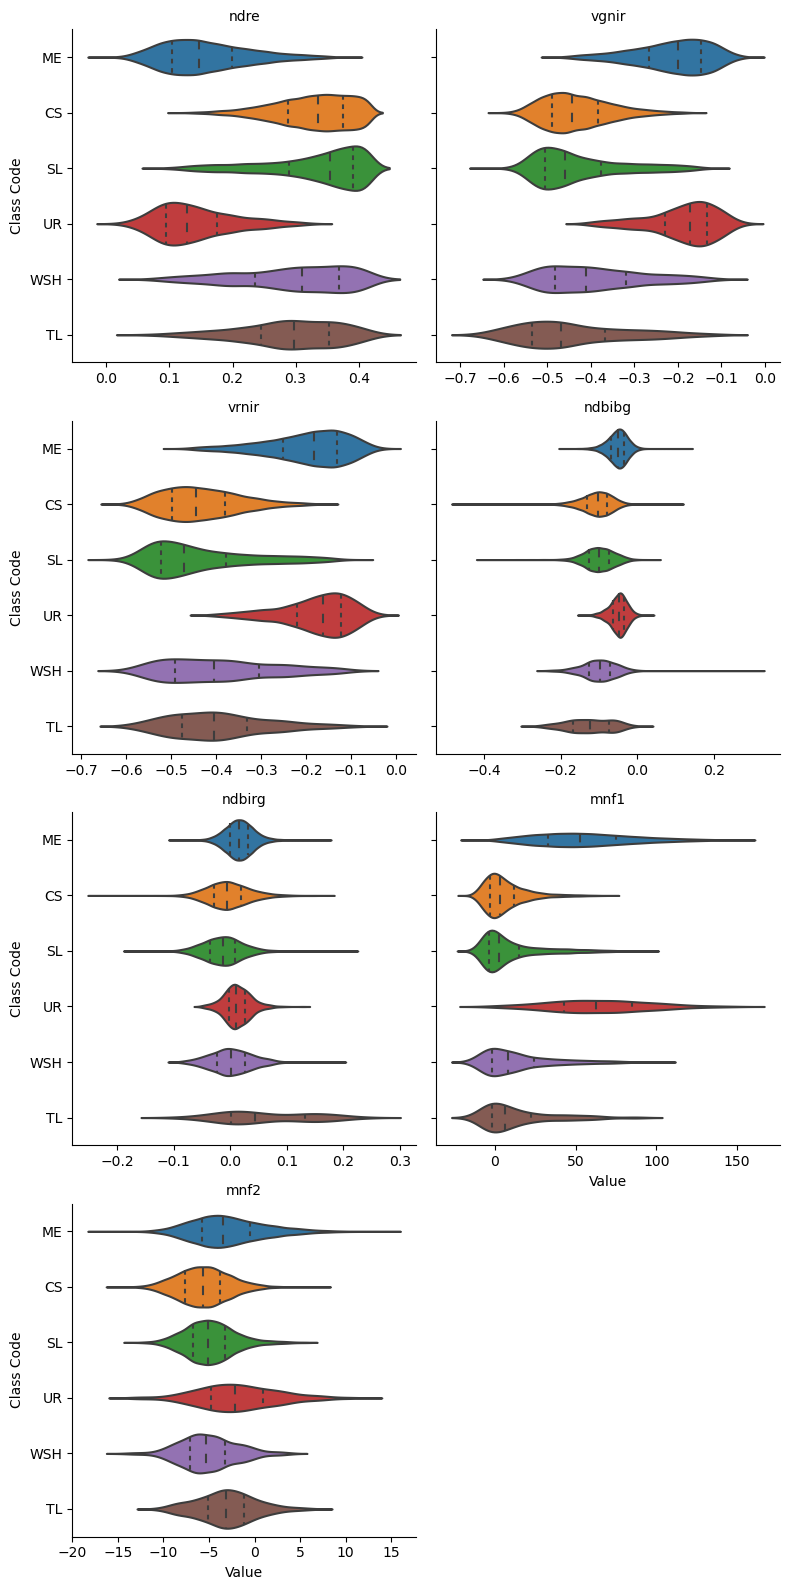

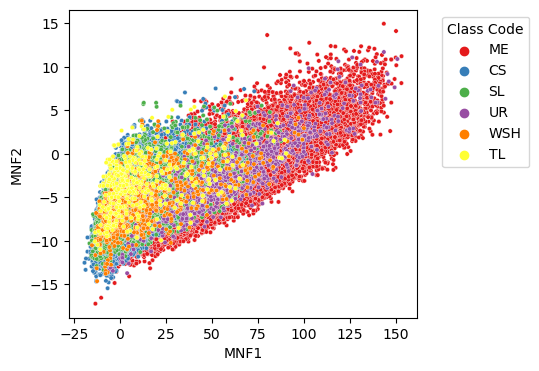

['ME' 'CS' 'SL' 'UR' 'WSH' 'TL']


In [4]:
# Get the summary of each endmember class spectral response)
summary_stats = ref_sp.groupby('class_code')[['mnf1']].describe()
print(summary_stats)

#################################
# Plots of the spectral library #
#################################

# Create horizontal violin plot facet grid

# Melt the DataFrame to long format
ref_sp_m = ref_sp.melt(
    id_vars=['class_code'],
    value_vars=['ndre','vgnir','vrnir','ndbibg','ndbirg','mnf1','mnf2'],
    var_name='Band',
    value_name='Value')

# Create a facet plot
g = sns.catplot(data=ref_sp_m, x='Value', y='class_code', col='Band',
                kind='violin', sharey=True, sharex=False, inner='quartile', col_wrap=2, height=4)

# Adjusting the titles and axis labels (if needed)
g.set_titles("{col_name}")
g.set_axis_labels("Value", "Class Code")
# Display the plot
plt.show()

# Create a scatter plot with MNF1 and MNF2, colored by class code
plt.figure(figsize=(4.5, 4))
sns.scatterplot(x='mnf1', y='mnf2', hue='class_code', data=ref_sp, palette='Set1', s=10)
plt.xlabel('MNF1')
plt.ylabel('MNF2')
plt.legend(title='Class Code', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

# Create an array of the class means
print(ref_sp['class_code'].unique())
class_codes = ref_sp['class_code'].unique()

Shape: (7, 7555, 6046); 
NoData Value: None; 
Bands: <xarray.DataArray 'band' (band: 7)>
array([1, 2, 3, 4, 5, 6, 7])
Coordinates:
  * band         (band) int64 1 2 3 4 5 6 7
    spatial_ref  int64 0; 
Band Names: ('ndre', 'vgnir', 'vrnir', 'ndbibg', 'ndbirg', 'mnf1', 'mnf2'); 
Data Type: float64


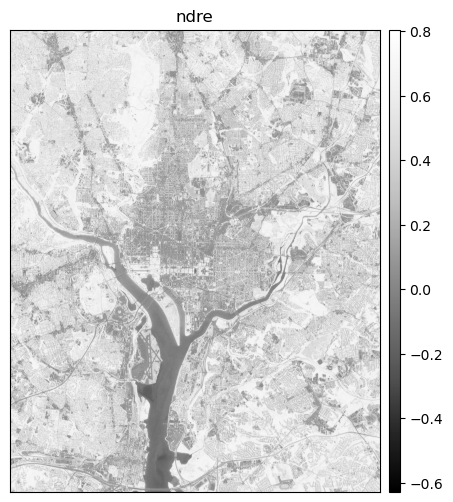

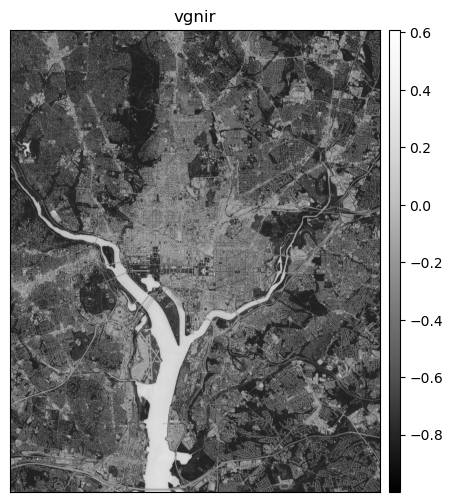

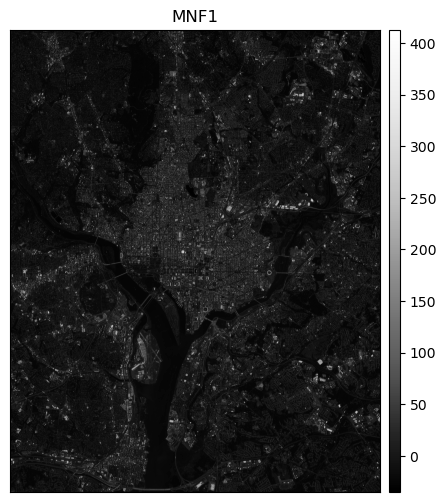

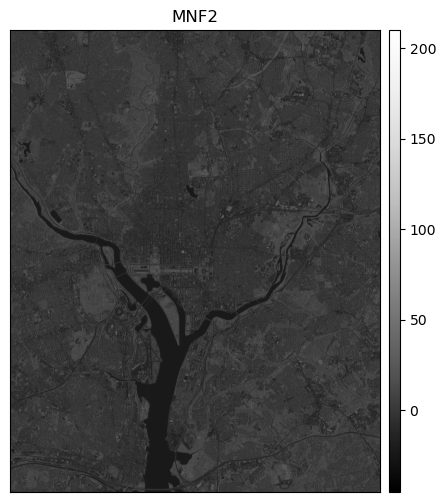

<Axes: title={'center': 'MNF2'}>

In [5]:
# Bring in the image file and get the projection information
mnf_path = os.path.join(maindir,"data/spatial/mod/dc_data/planet-data/dc_data_psscene13b_mnf_ind.tif")
stack_mnf = rxr.open_rasterio(mnf_path)
print(
    f"Shape: {stack_mnf.shape}; \n"
    f"NoData Value: {stack_mnf.rio.nodata}; \n"
    f"Bands: {stack_mnf.band}; \n"
    f"Band Names: {stack_mnf.long_name}; \n"
    f"Data Type: {stack_mnf[0].dtype}")
# Plot one image as an example (green band)
ep.plot_bands(stack_mnf[0], title=["ndre"], figsize=(6,6))
ep.plot_bands(stack_mnf[1], title=["vgnir"], figsize=(6,6))
ep.plot_bands(stack_mnf[5], title=["MNF1"], figsize=(6,6))
ep.plot_bands(stack_mnf[6], title=["MNF2"], figsize=(6,6))

In [12]:
# Clip the image stack to the DC area
dc = gpd.read_file(os.path.join(maindir,'data/spatial/raw/dc_data/boundaries/district_of_columbia.gpkg')).to_crs(proj)
stack_mnf_cl = stack_mnf.rio.clip(dc.geometry)

In [16]:
# Grab projection information
# Get the WKT and GeoTransform
gdal.UseExceptions()  # Enable errors
try:
    ds = gdal.Open(mnf_path)
    gt = ds.GetGeoTransform()
    wkt = ds.GetProjection()
except RuntimeError:  # <- Check first what exception is being thrown
    pass
del ds
print(f"GeoTransform: {gt}; \nWKT: {wkt}")

GeoTransform: (316269.0, 3.0, 0.0, 4318296.0, 0.0, -3.0); 
WKT: PROJCS["WGS 84 / UTM zone 18N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-75],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32618"]]


In [35]:
# Load the KMeans-based endmembers
ems = pd.read_csv(os.path.join(maindir,'data/tabular/mod/dc_data/training/dc_data_endmembers_kmeans.csv'))
ems = ems[['class_name','ndre','vgnir','vrnir','ndbibg','ndbirg','mnf1','mnf2']]
print(ems.head())

print(ems['class_name'].unique())

ems_ = ems.drop('class_name', axis=1)

ems_arr = ems_.values

# Loop and create a list of arrays (the first set for each material type
ems_arr_m = {}
for cl in ems['class_name'].unique():
    arr = {}
    sub = ems[ems['class_name'] == cl]
    sub = sub.drop('class_name', axis=1)
    ems_arr_m[cl] = sub.values
print(ems_arr_m)

  class_name      ndre     vgnir     vrnir    ndbibg    ndbirg        mnf1  \
0         ME  0.093271 -0.113486 -0.130944 -0.069587 -0.017722   84.235954   
1         ME  0.149339 -0.213488 -0.211797 -0.072629  0.001771   39.855995   
2         ME  0.121904 -0.166700 -0.162060 -0.049271  0.004769   61.020460   
3         ME  0.234510 -0.321578 -0.314222 -0.091400  0.008183   17.134134   
4         ME  0.082754 -0.109527 -0.061508 -0.028216  0.048344  114.173850   

       mnf2  
0 -0.017012  
1 -4.704653  
2 -2.780414  
3 -6.721263  
4  3.986176  
['ME' 'CS' 'SL' 'UR' 'WSH' 'TL']
{'ME': array([[ 9.32711500e-02, -1.13486010e-01, -1.30944180e-01,
        -6.95865750e-02, -1.77215190e-02,  8.42359540e+01,
        -1.70116820e-02],
       [ 1.49339210e-01, -2.13488370e-01, -2.11797490e-01,
        -7.26292400e-02,  1.77095630e-03,  3.98559950e+01,
        -4.70465330e+00],
       [ 1.21904396e-01, -1.66699950e-01, -1.62060050e-01,
        -4.92709900e-02,  4.76871700e-03,  6.10204600e+01,
 

In [39]:
############################################
# Fully Constrained Least Squares Unmixing #
# Linear Spectral Mixture Analysis (LSMA)  #
# Single endmember per group               #
############################################

stack_mnf_arr = np.asarray(stack_mnf)  # ensure that the MNF is a numpy array

import time
import traceback

num_processes = mp.cpu_count() - 1
print(f"Splitting across {num_processes} chunks for work ...")

# Check the data shapes
print(f"Image array (MNF) shape: {stack_mnf_arr.shape}; Endmember array shape: {ems_arr.shape}")

# Split the MNF-transformed stack into chunks to be processed
chunks = np.array_split(stack_mnf_arr, num_processes, axis=2)

# Set up to run for each combination of endmembers
num_iterations = 5

for i in range(num_iterations):
    print(f'Starting iteration {i+1}')
    
    # Construct the endmember array for this iteration
    ems_arr = np.array([ems_arr_m[cls][i, :] for cls in ems_arr_m.keys()])
    print(ems_arr)
    
    # Check the data shapes
    print(f"Image array (MNF) shape: {stack_mnf_arr.shape}; Endmember array shape: {ems_arr.shape}")

    # Perform FCLS unmixing in parallel
    start_time = time.time()
    if __name__ == '__main__':

        # Function to parallelize FCLS unmixing
        def parallel_fcls_unmixing(chunk, endmembers):
            try:
                am = amap.FCLS()
                return am.map(chunk.T, endmembers, normalize=False)
            except Exception as e:
                traceback.print_exc()
                raise e

        with mp.Pool(processes=num_processes) as pool:
            try:
                unmix_results = pool.map(partial(parallel_fcls_unmixing, endmembers=ems_arr), chunks)
                pool.close()
            except Exception as e:
                traceback.print_exc()
                raise e
            finally:
                pool.terminate()
                pool.join() 

    print(f"Time elapsed for iteration {i+1}: {round(time.time() - start_time, 1)/60} minutes.") 

print(f"Time elapsed for all iterations: {round(time.time() - start_time, 1)/60} minutes.") 


Splitting across 7 chunks for work ...
Image array (MNF) shape: (7, 7555, 6046); Endmember array shape: (6, 7)
Starting iteration 1
[[ 9.32711500e-02 -1.13486010e-01 -1.30944180e-01 -6.95865750e-02
  -1.77215190e-02  8.42359540e+01 -1.70116820e-02]
 [ 3.09964120e-01 -4.49602930e-01 -4.25653340e-01 -1.69370530e-01
   2.96176630e-02  1.86297500e+00 -5.81563430e+00]
 [ 3.15640300e-01 -3.73688460e-01 -3.93178730e-01 -1.33398250e-01
  -2.28471010e-02  1.12107315e+01 -4.30812300e+00]
 [ 1.52922660e-01 -1.97465260e-01 -1.80572350e-01 -3.64308360e-02
   1.75175180e-02  5.65953670e+01 -2.96440480e+00]
 [ 3.16885100e-01 -3.93148450e-01 -3.90879480e-01 -9.41176500e-02
   2.68096520e-03  1.15205590e+01 -5.13020750e+00]
 [ 2.79695300e-01 -4.64052300e-01 -4.01459840e-01 -1.26502570e-01
   7.69230800e-02  8.83952200e+00 -2.94780920e+00]]
Image array (MNF) shape: (7, 7555, 6046); Endmember array shape: (6, 7)


KeyboardInterrupt: 

In [ ]:
# Retrieve the results
print(type(unmix_results))
print(len(unmix_results))
# Combine the FCLS results from all chunks back into a single array
ams_combined_parallel = np.concatenate(unmix_results)
print(f"Final combined array shape: {ams_combined_parallel.shape}")

In [ ]:
print(gt, wkt)

In [ ]:
# Export the abundance ndarray as a multiband raster
import xarray as xr

print(f"Original shape: {stack_mnf.shape}; \nAbundance maps shape: {ams_combined_parallel.shape}")
print(f"Length of 'y' attribute: {stack_mnf.y}; \nLength of shape[1]: {ams_combined_parallel.shape[1]}")

# Transpose the new array before exporting
in_arr = ams_combined_parallel.transpose(2, 1, 0)
print(in_arr.shape)

# Assign the correct coordinates for the transposed 'y' dimension
band_coords = range(in_arr.shape[0])
y_coords = stack_mnf.y.values
x_coords = stack_mnf.x.values

# Store the new array and export
out_arr = xr.DataArray(
    in_arr,
    dims=("band", "y", "x"),
    coords={
        "band": band_coords,
        "y": y_coords,
        "x": x_coords,
    }
)

# Export the new DataArray as a new GeoTIFF file
# Assign projection information
out_arr.rio.set_crs(stack_mnf.rio.crs)  # Set the CRS
out_arr.rio.write_transform(stack_mnf.rio.transform())  # Set the GeoTransform
# out_arr = out_arr.rio.clip(dc.geometry)  # clip to DC county
output_path = "fcls_abundances_median.tif"
out_arr.rio.to_raster(output_path, compress='zstd', zstd_level=9,
                      dtype='float32', driver='GTiff')  # export to GeoTIFF
print("Success !! ...")

In [ ]:
# Test the output by plotting the abundance maps
groups = ref_sp['class_code'].unique()
for i in range(len(groups)):
    print(f"Class {i}: {groups[i]}")
ep.plot_bands(
    ams_combined_parallel.T,
    scale=False,
    figsize=(10,10))

In [ ]:
# Create and export a masked version (masking out vegetation and water)

# Mask the MNF data using the veg/water & built-up mask

print(type(ams_combined_parallel.T))
print(ams_combined_parallel.T.shape)

mask = np.logical_xor(veg_mask, water_mask).astype(int)  # Convert boolean array to integer (1 or 0)

# Apply the combined mask to the original 7-band raster
ams_combined_parallel_masked = np.where(mask == 0, ams_combined_parallel.T, np.nan)  # Set to np.nan where the mask is 0

print(ams_combined_parallel_masked.shape)  # Should still be (7, 7555, 6046)

ep.plot_bands(ams_combined_parallel_masked[0],figsize=(4,4))
ep.plot_bands(ams_combined_parallel_masked[5],figsize=(4,4))

# Assign the correct coordinates for the transposed 'y' dimension

in_arr = ams_combined_parallel.T

band_coords = range(in_arr.shape[0])
y_coords = stack_mnf.y.values
x_coords = stack_mnf.x.values

# Store the new array and export
out_arr_ = xr.DataArray(
    in_arr,
    dims=("band", "y", "x"),
    coords={
        "band": band_coords,
        "y": y_coords,
        "x": x_coords,
    }
)

# Export the new DataArray as a new GeoTIFF file
# Assign projection information
out_arr_.rio.set_crs(stack_mnf.rio.crs)  # Set the CRS
out_arr_.rio.write_transform(stack_mnf.rio.transform())  # Set the GeoTransform
# out_arr = out_arr.rio.clip(dc.geometry)  # clip to DC county
output_path = "fcls_abundances_median_masked.tif"
out_arr_.rio.to_raster(output_path, compress='zstd', zstd_level=9,
                      dtype='float32', driver='GTiff')  # export to GeoTIFF
print("Success !! ...")